Before starting to work on the data, we need to obtain the data from the data sources. In order to do so I used web scraping technique and pandas read_csv function to collect the data.

# Web Scraping - daily_treasury_yield_curve_rate

In [ ]:
import requests
from lxml import html
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup as bs
from datetime import datetime

In [ ]:
URL = 'https://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData'
COLUMNS = ['Date','1 Mo','2 Mo','3 Mo','6 Mo','1 Yr','2 Yr','3 Yr','5 Yr','7 Yr','10 Yr','20 Yr','30 Yr']

In [ ]:
def process_data(soup):
    data = soup.find_all('m:properties')[0]
    data = data.text
    data = data.split('\n')
    data = data[2:-2]
    return data

def create_new_row(data,columns):
    new_row = dict()
    
    for idx,(key,value) in enumerate(zip(columns,data)):
        if idx == 0:
            value = datetime.strptime(value, '%Y-%m-%dT%H:%M:%S')
        else:
            value = round(float(value),2) if value != '' else 0
                
        new_row[key] = value
        
    return new_row

def get_data_from_link(link,columns):
    sauce = urllib.request.urlopen(link).read()
    soup = bs(sauce,'xml')
    data = process_data(soup)
    new_row = create_new_row(data,columns)
    return new_row

sauce = urllib.request.urlopen(URL).read()
soup = bs(sauce,'xml')
df = pd.DataFrame(columns=COLUMNS)
for idx,link in enumerate(soup.find_all('id')):
    if idx>0:
        daily_yield_curve_rate_data = get_data_from_link(link.text,COLUMNS)
        df = df.append(daily_yield_curve_rate_data,ignore_index=True)

df.to_csv('daily_treasury_yield_curve_rate.csv')


# Web Scraping - BAA10Y

In [ ]:
import pandas as pd
import io
import requests

URL = r'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=BAA10Y&scale=left&cosd=1986-01-02&coed=2019-12-03&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-12-05&revision_date=2019-12-05&nd=1990-02-02'
c = pd.read_csv(URL)
print(c)

# Read data

In [1]:
import pandas as pd
import numpy as np

daily_treasury_yield_curve_rate_df = pd.read_csv('daily_treasury_yield_curve_rate.csv',
                                                 parse_dates=['Date'], index_col='Date')
baa10y_df = pd.read_csv('BAA10Y.csv', parse_dates=['DATE'], index_col='DATE')

In [2]:
PERIODS = ['3 Mo','1 Yr','5 Yr','10 Yr','30 Yr']
FONT_SIZE = 10
FIGSIZE = (10,5)
START_DATE='1990-01-01'
END_DATE = '2006-01-01'

In [3]:
def prepare_data(df, interest_periods, data_source,
                 start_date='1990-01-01', end_date = '2020-01-01',
                 fill=False, add_freq=False, freq='3m'):
    
    if data_source == 'yield':
        data = df[interest_periods]
    elif data_source == 'baa10y':
        data = df[interest_periods]
        data = data.replace('.',np.nan)
        data = data.dropna()
        data = data.astype(float)
        
    data = data.loc[start_date:end_date]
    data = data.sort_index(axis=0)

    if add_freq:
        data = data.asfreq(freq=freq)

    if fill:
        data = data.fillna(method='ffill')

    return data

In [4]:
def create_data_df(use='std'):
    data_df = pd.DataFrame()
    for period in PERIODS:
        if use == 'std':
            data = prepare_data(daily_treasury_yield_curve_rate_df, 
                                interest_periods=period,
                                data_source='yield',
                                end_date=END_DATE)
        elif use == 'seasonal_decompose':
            data = prepare_data(daily_treasury_yield_curve_rate_df,
                        interest_periods=period,
                        data_source='yield',
                        start_date=START_DATE,
                        end_date=END_DATE,
                        fill=True, add_freq=True, freq='3m')
        elif use == 'adfuller':
            data = prepare_data(daily_treasury_yield_curve_rate_df,
                        interest_periods=period,
                        data_source='yield',
                        start_date=START_DATE,
                        end_date=END_DATE,
                        fill=True)
        data_df = add_data_to_df(data_df, period, data)
    if use == 'std':
        data = prepare_data(baa10y_df, 
                            interest_periods='BAA10Y', 
                            data_source='baa10y',
                            start_date=START_DATE, 
                            end_date=END_DATE)
    elif use == 'seasonal_decompose':
        data = prepare_data(baa10y_df,
                        interest_periods='BAA10Y',
                        data_source='baa10y',
                        start_date=START_DATE,
                        end_date=END_DATE,
                        fill=True, add_freq=True, freq='3m')
    elif use == 'adfuller':
        data = prepare_data(baa10y_df,
                    interest_periods='BAA10Y',
                    data_source='baa10y',
                    start_date=START_DATE,
                    end_date=END_DATE,
                    fill=True)
    data_df = add_data_to_df(data_df, 'BAA10Y', data)
    
    return data_df

In [5]:
def add_data_to_df(df, header, data):
    df_to_add = pd.DataFrame(data={header: data})
    df = pd.concat([df, df_to_add], axis=1)
    return df

In [6]:
def old_plot_data(data, xlabel='', ylabel='', title=''):
    plt.figure(figsize=FIGSIZE)
    ax = plt.axes()
    ax.tick_params(axis='both', labelsize=FONT_SIZE)
    plt.xlabel(xlabel, fontdict={'size':FONT_SIZE})
    plt.ylabel(ylabel)
    plt.title(title)
    data.plot()
    
def plot_data(df, title):
    fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(data, color='blue', linewidth=1)
    # Decorations
        ax.set_title(title + ' of ' + df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout();

# 1.a Finding trend and seasonality

We can decompose time series to 3 main components: trend, seasonality, and noise (random vairable).
There are 2 main models that uses these components:

1. Additive model: y = trend + seasonality + noise
2. Multiplicative model: y = trend x seasonality x noise

In multiplicative model the variance of the seasonality is increasing (or decreasing) over time, while in additive model the varaince of the seasonality doesn't change much.
I used seasonal_decompose function (from statsmodels package) to decompose the time series into trend and seasonality. This function requires:

1. Model type. 
2. Frequency (which can be thought of as the seasonality)
3. No missing data. 

Due to this, I checked the rolling standart deviation of each time series to decide the model type. Furthermore, for seasonality  period of time of 1 quarter (3 months) is used. (The seasonality changes for different periods of time).

In this section, we were asked to work on data between 1990 to 2005.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

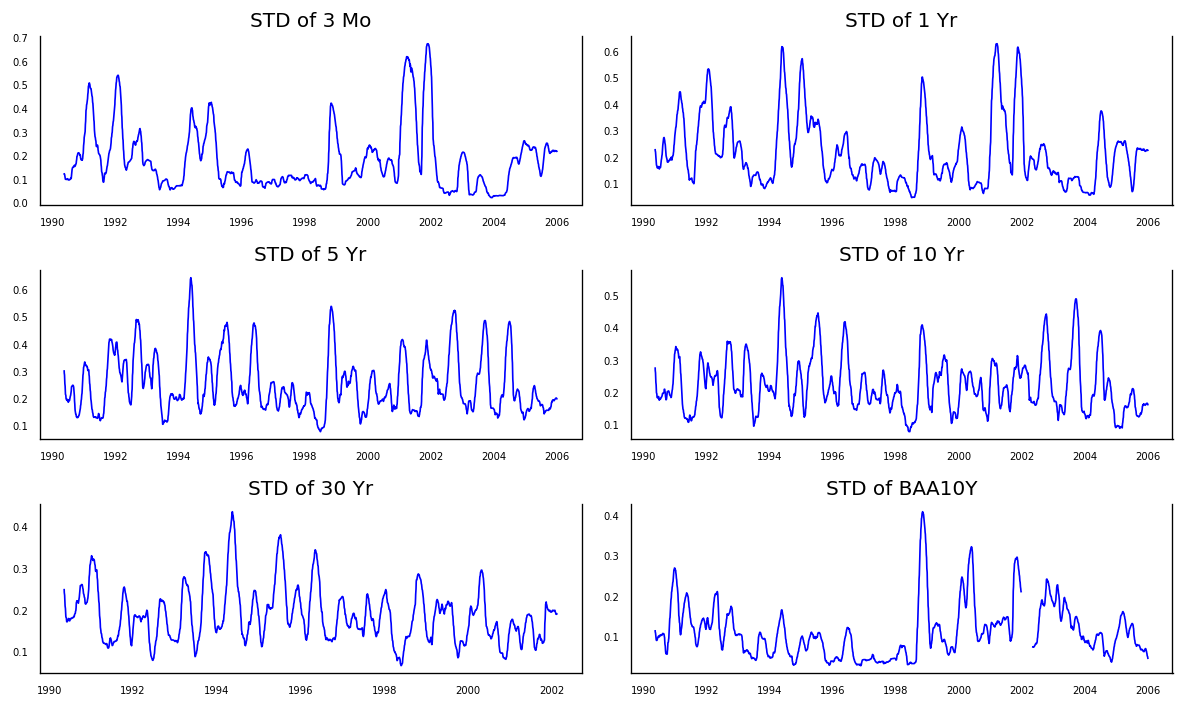

In [8]:
df_std = pd.DataFrame()
data_df = create_data_df(use='std') 

for name, series in data_df.iteritems():
    data = series.rolling(window=90).std()
    df_std = add_data_to_df(df_std, name, data)

plot_data(df_std, 'STD')

Since the standart deviation is not increasing or decresing over time, but volatile, *I chose to use the addtive model*.

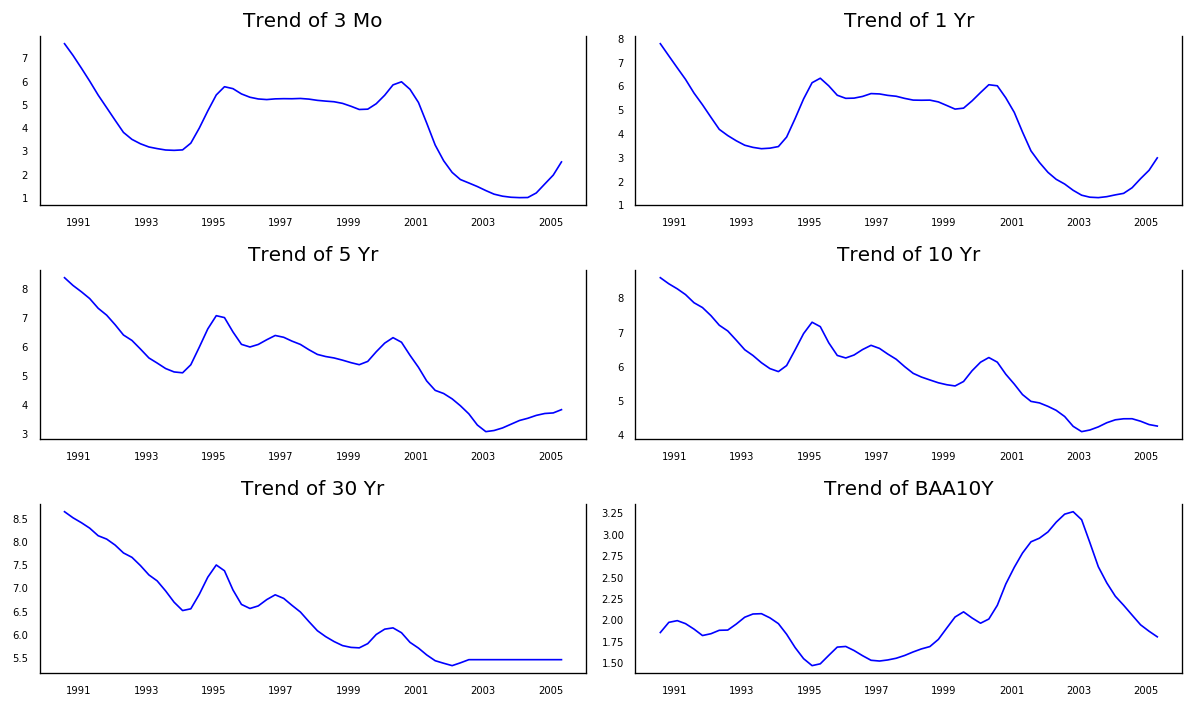

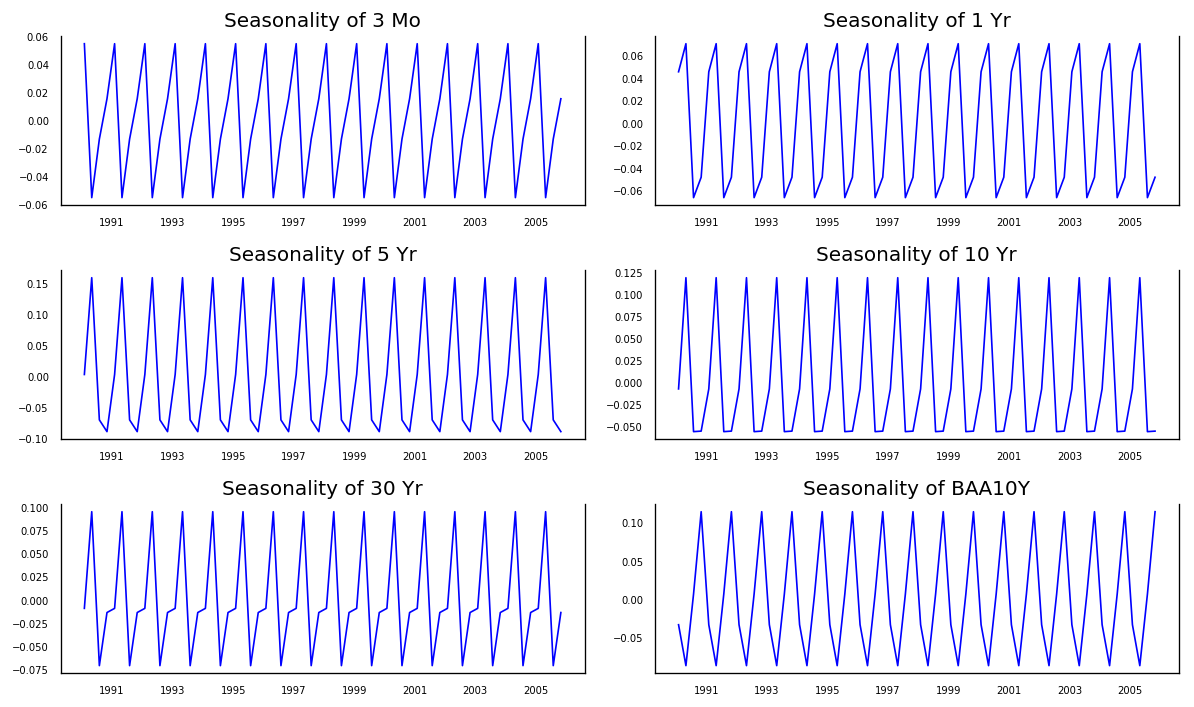

In [9]:
trend_df = pd.DataFrame()
seasonal_df = pd.DataFrame()
data_df = create_data_df(use='seasonal_decompose')

for name, series in data_df.iteritems():
    result = seasonal_decompose(series, model='additive')
    trend_df = add_data_to_df(trend_df, name, result.trend)
    seasonal_df = add_data_to_df(seasonal_df, name, result.seasonal)

plot_data(trend_df, 'Trend')
plot_data(seasonal_df, 'Seasonality')

As can be seen, the trend is a smoothed average of the no risk interest.
The values of trend are between 1 to 8 while the values of seasonality are between -0.1 to 0.15, 
meaning the seasonality barely has any effect. It can be thought of that there is not seasonality for this period.

# 1.b Checking stationarity and unit root

The properties (definition) of (weak) stationarity time series is:

1. Constant mean: for all t: E[y(t)] = M
2. Auto covariance depends only on the diffrenece in time: for all u,v,k cov(y(u),y(v)) = cov(y(u+a),y(v+a))
    
It can be inferred from the definition that in stationary time series there isn''t trend or seasonality. 
In all periods there is a trend, so we can assume that all serieses are not stationary.

For formality, I used Augmented Dickey-Fuller test, which is a statisitcal method which checks if time series is stationary:
1. The null hypothesis (H0) suggests that the is a unit root, meaning the series is not stationary . 
The alternative hypothesis (H1) suggests that there is not an unit root and that the series is stationary.
2. We fail to reject H0 if p-value > 0.05. (non stationary). 
We reject H0 if p-value <= 0.05 (statonary)

In [10]:
from statsmodels.tsa.stattools import adfuller

In [14]:
data_df = create_data_df(use='adfuller') 
data_df = data_df.dropna()

for name, series in data_df.iteritems():
    result = adfuller(series.values)
    p_value = result[1]
    
    print('p-value for period {period} is: {p_value}'.format(period=name, p_value=p_value))
    if p_value <= 0.05:
        print('Time series of no risk interest for {period} is stationary with no unit root\n'.
              format(period=name))
    else:
        print('Time series of no risk interest for {period} is not stationary and there is a unit root\n'.
              format(period=name))

p-value for period 3 Mo is: 0.21646900899987137
Time series of no risk interest for 3 Mo is not stationary and there is a unit root

p-value for period 1 Yr is: 0.22772218425521695
Time series of no risk interest for 1 Yr is not stationary and there is a unit root

p-value for period 5 Yr is: 0.4394758145341298
Time series of no risk interest for 5 Yr is not stationary and there is a unit root

p-value for period 10 Yr is: 0.5053310568860641
Time series of no risk interest for 10 Yr is not stationary and there is a unit root

p-value for period 30 Yr is: 0.5094546211823368
Time series of no risk interest for 30 Yr is not stationary and there is a unit root

p-value for period BAA10Y is: 0.24114541439083315
Time series of no risk interest for BAA10Y is not stationary and there is a unit root



# 1.c Co-Integration test

Before applying the Co-integration test we need to transform each time series to a stationary time series.
It can be done by trnasforming the time series to the 1 lag difference time series: 
y_t = x_t - x_t-1 (where x is the original time series and x_t is the value of the series at time t).

In [15]:
stationary_df = pd.DataFrame()

for name, series in data_df.iteritems():
    series_diff = series.diff(periods=1)
    series_diff = series_diff.dropna()
    result = adfuller(series_diff.values)
    p_value = result[1]
    print('p_value of period {period}: {p_value}'.format(period=name, p_value=p_value))
    if p_value < 0.05:
        print('stationary')
        data_to_add_df = pd.DataFrame(data = {name: series_diff})
        stationary_df = pd.concat([stationary_df,data_to_add_df], axis=1)
    else:
        print('not stationary')

p_value of period 3 Mo: 4.9472896466929466e-17
stationary
p_value of period 1 Yr: 1.566922131447192e-18
stationary
p_value of period 5 Yr: 0.0
stationary
p_value of period 10 Yr: 0.0
stationary
p_value of period 30 Yr: 0.0
stationary
p_value of period BAA10Y: 6.385803577854462e-24
stationary


(4000, 6)


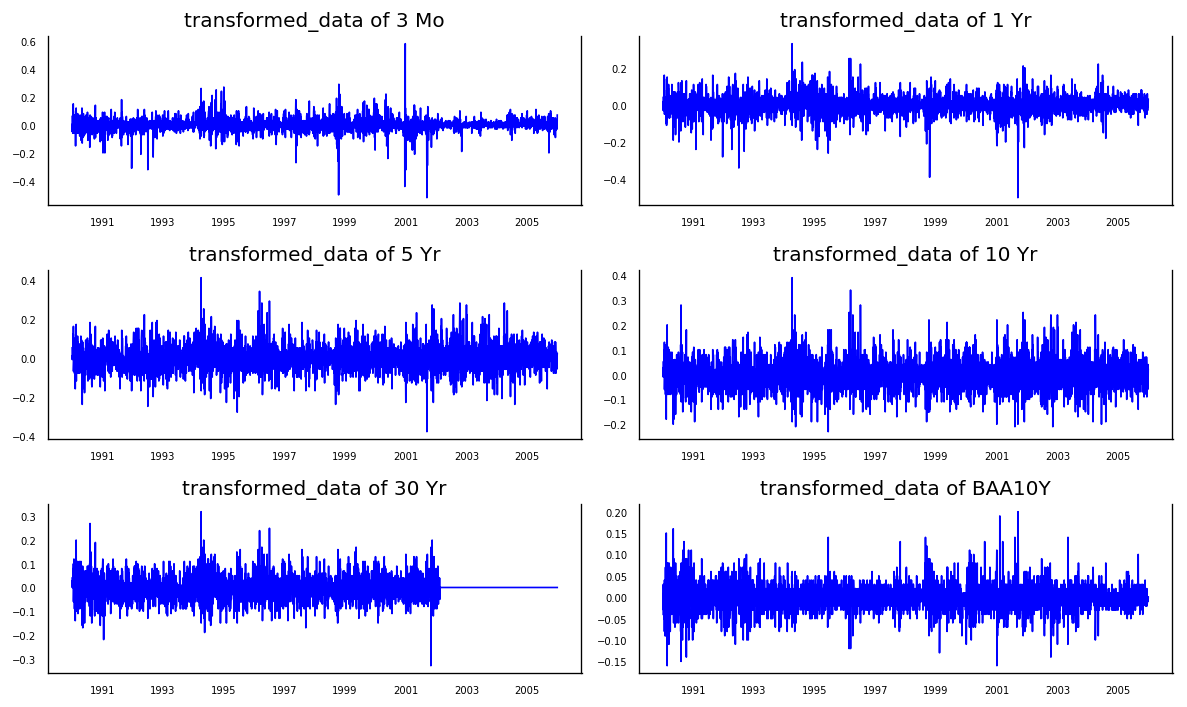

In [16]:
plot_data(stationary_df, 'transformed_data')

Now that the data is stationary we can check if co-integration exists using johansen test.
I applied the test for several (5) lags.

In [21]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

for lag in range(1,6):
    print("lag = {lag}".format(lag=lag))
    print('#'*50)
    res = select_coint_rank(stationary_df, 1, lag, method='trace')
    print(res.summary())

lag = 1
##################################################
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6      1.056e+04          107.3
  1   6          8396.          79.34
  2   6          6512.          55.25
  3   6          4696.          35.01
  4   6          3039.          18.40
  5   6          1472.          3.841
-------------------------------------
lag = 2
##################################################
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6          7676.          107.3
  1   6          6058.          79.34
  2   6          4692.          55.25
  3   6          3425.          35.01
  4   6          2182.          18.40
  5   6          1060.          3.841
-------------------------------------
lag = 3
##########################

# 1.d

It can be seen that for each lag the johansen output the hishest possible rank:
For each rank the test statistic is higher than the critical value.
Now we can use a VAR (Vector auto regressive) model to predict future values.

In [23]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
mod = smt.VAR(stationary_df)
res = mod.fit(maxlags=1)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, Jan, 2020
Time:                     16:47:23
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -42.0933
Nobs:                     3999.00    HQIC:                  -42.1359
Log likelihood:           50293.7    FPE:                4.90249e-19
AIC:                     -42.1594    Det(Omega_mle):     4.85132e-19
--------------------------------------------------------------------
Results for equation 3 Mo
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.000911         0.000738           -1.233           0.218
L1.3 Mo           0.022119         0.020385            1.085           0.278
L1.1 Yr           0.099463         0.030443            3.267           0.001


C:\Users\noamarbe\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [26]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(res.resid)

for col, val in zip(stationary_df.columns, out):
    print((col), ':', round(val,2))

3 Mo : 1.99
1 Yr : 2.0
5 Yr : 2.0
10 Yr : 2.0
30 Yr : 2.0
BAA10Y : 2.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

daily_treasury_yield_curve_rate_df = pd.read_csv('daily_treasury_yield_curve_rate.csv',
                                                 parse_dates=['Date'], index_col='Date')
start_period = 11
end_period = 12
for idx,period in enumerate(COLUMNS[start_period:end_period]):
    data = daily_treasury_yield_curve_rate_df[COLUMNS[idx+start_period]]
    data = data.sort_index(axis=0)
    data.plot(x='date',y='daily_treasury_yield_curve_rate',figsize=(20,10))
    rolling_mean = data.rolling(window=30).mean()
    rolling_mean.plot(label='rolling mean')
#     rolling_std = data.rolling(window=30).std()
#     rolling_std.plot(label='rolling std')
#     plt.legend(loc='best')
    mean_list = list(map(lambda idx: data[data.index < idx].mean(),data.index))        
    plt.plot([i for i in range(len(mean_list))], mean_list)

    data = data.diff(periods=30)
    mean_list = list(map(lambda idx: data[data.index < idx].mean(),data.index))    
    print(min(mean_list[1000:]))
    print(max(mean_list[1000:]))
    plt.plot([i for i in range(len(mean_list))], mean_list)

In [ ]:
passengers = pd.read_csv('airline-passengers.csv',parse_dates=['Month'], index_col='Month')
passengers.plot()

In [ ]:
rolling_std = passengers.rolling(window=30).std()
rolling_std.plot(label='rolling std')